In [1]:
import numpy as np
from numpy import sin, pi, arange
from matplotlib import pyplot as plt
import pandas as pd
import scipy

# Signal

(3001,)


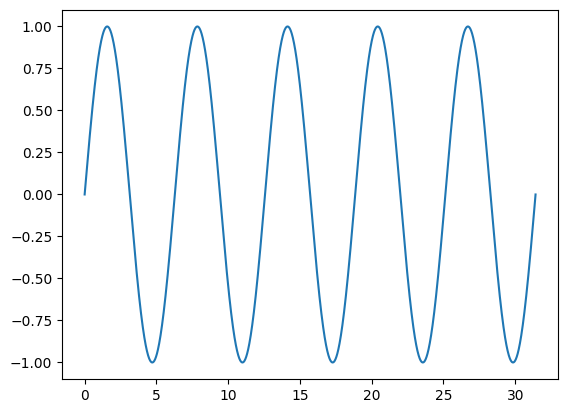

In [63]:
timepoints = arange(0, 10 * pi, pi / 300)
s = sin(timepoints)
print(timepoints.shape)
plt.plot(timepoints, s)

# My Implementation (Pure Python)

In [64]:
def autocorrelation(s: np.ndarray, lag: int):
    if lag == 0:
        return 1

    sd = s - s.mean()  # demean
    summ = (sd[:-lag] * sd[lag:]).sum()
    C_lag = summ / (len(s) * s.var())
    return C_lag

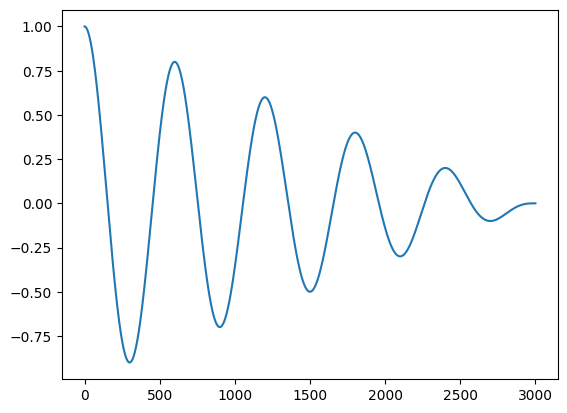

In [65]:
corr_python = []
for lag in range(len(s)):
    corr_python.append(autocorrelation(s, lag))

plt.plot(corr_python)

# Numpy

In [68]:
corr_np_valid = np.correlate(s, s, 'valid')
corr_np_valid_normalized = corr_np_valid / (s.var() * len(s))
print(corr_np_valid_normalized)

[1.]


(6001,)


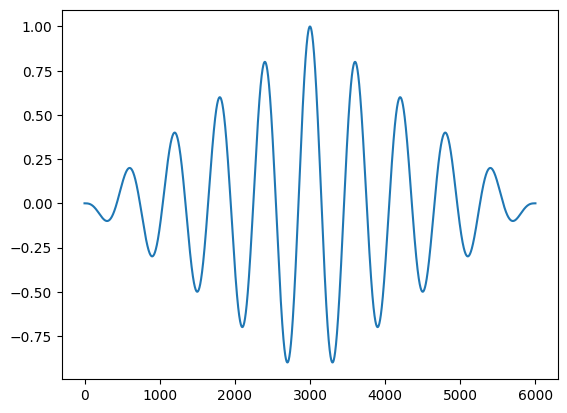

In [77]:
corr_np = np.correlate(s, s, 'full')
print(corr_np.shape)
corr_np_normalized = corr_np / (s.var() * len(s)) # this is not necessary if we just want to find the half max (maybe also less robust)
plt.plot(corr_np_normalized)

In [70]:
middle = corr_np.shape[0] / 2
middle

3000.5

/Users/julian/Developer/SeizurePredictionThesisVenv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/julian/Developer/SeizurePredictionThesisVenv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/julian/Developer/SeizurePredictionThesisVenv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


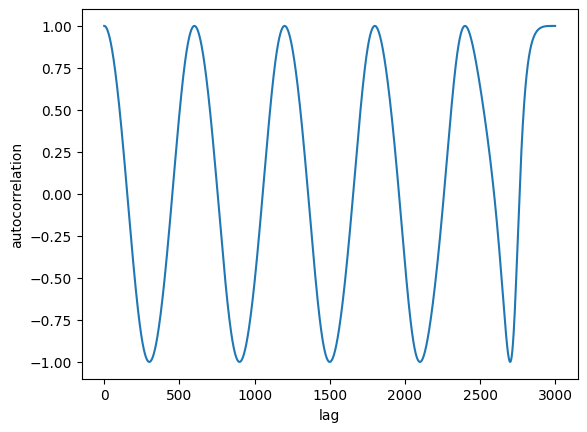

In [71]:
s_ = pd.Series(s)
corr_pandas = []

for lag in range(len(s)):
    corr_pandas.append(s_.autocorr(lag))
plt.plot(corr_pandas)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.show()

# Scipy

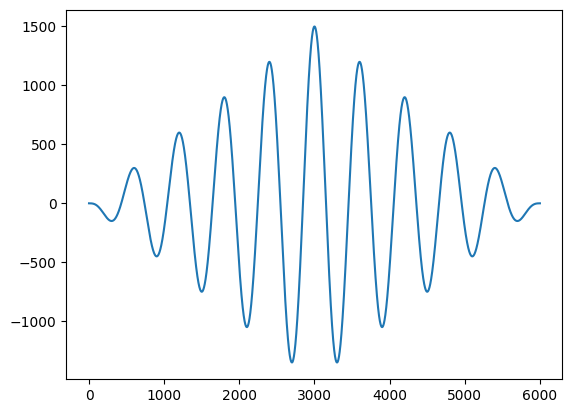

In [72]:
corr_scipy = scipy.signal.correlate(s, s, )
plt.plot(corr_scipy)

In [73]:
np.corrcoef(s[:])

np.float64(1.0)

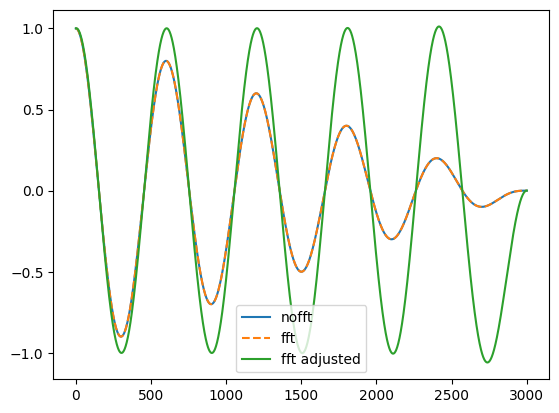

In [119]:
from statsmodels.tsa import stattools

corr_statsmodels_nofft = stattools.acf(s,nlags=len(s), fft=True)
corr_statsmodels_fft = stattools.acf(s,nlags=len(s), fft=True)
corr_statsmodels_fft_adjusted = stattools.acf(s,nlags=len(s), adjusted=True, fft=True)

plt.plot(corr_statsmodels_nofft, label='nofft', )
plt.plot(corr_statsmodels_fft, label='fft', linestyle='--')
plt.plot(corr_statsmodels_fft_adjusted, label='fft adjusted')
plt.legend()

# Speed Comparison
stattools.acf with fft=True is the fast and practical
scipy is faster, but the output doesn't have quite the format I want

In [100]:
import timeit

times = {}
calls = [
    'stattools.acf(s,nlags=s.shape[0], adjusted=True, fft=False)',
    'stattools.acf(s,nlags=s.shape[0], adjusted=True, fft=True)',
    "np.correlate(s, s, 'full')",
    'scipy.signal.correlate(s, s)'
    #'[autocorrelation(s, lag) for lag in range(len(s))]',
]

for call in calls:
    times[call] = timeit.timeit(call, number=10000, globals=globals())
    print(f"{call}: {times[call]}")

stattools.acf(s,nlags=s.shape[0], adjusted=True, fft=False): 5.505925958015723
stattools.acf(s,nlags=s.shape[0], adjusted=True, fft=True): 1.047344582999358
np.correlate(s, s, 'full'): 5.313641459011706
scipy.signal.correlate(s, s): 0.8368282089941204


# Autocorrelation function width (ACFW)

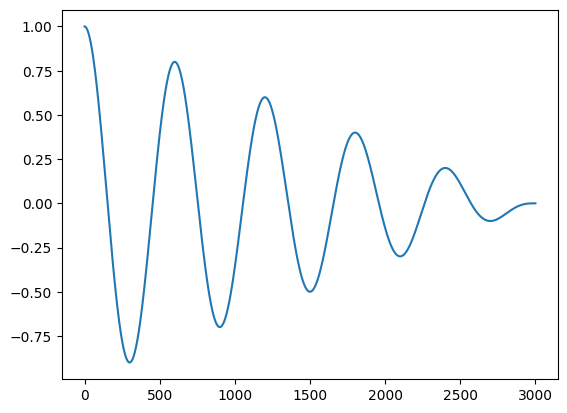

In [131]:
autocorr = stattools.acf(s, nlags=len(s), fft=True)
assert autocorr.max() == 1, "Autocorrelation max isn't 1"
plt.plot(autocorr)
plt.show()

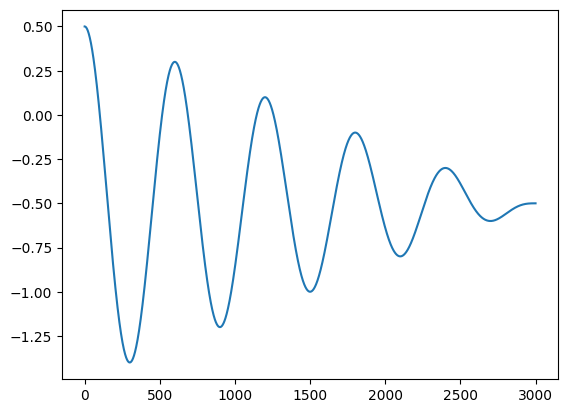

In [132]:
# Find the lag (index) where the ACF is closest to its half-max (=0.5)
autocorr_adj = autocorr - 0.5 # values close to 0.5 are now close to 0
plt.plot(autocorr_adj)
plt.show()

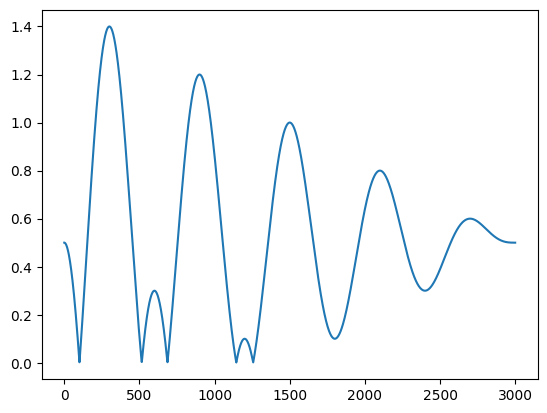

In [121]:
autocorr_adj_abs = np.abs(autocorr_adj) # Now only values close to 0 are minimal
plt.plot(autocorr_adj_abs)

In [134]:
lag = autocorr_adj_abs.argmin()
print(f"lag: {lag}")
print(autocorr[lag])

lag: 1145
0.501242202642491


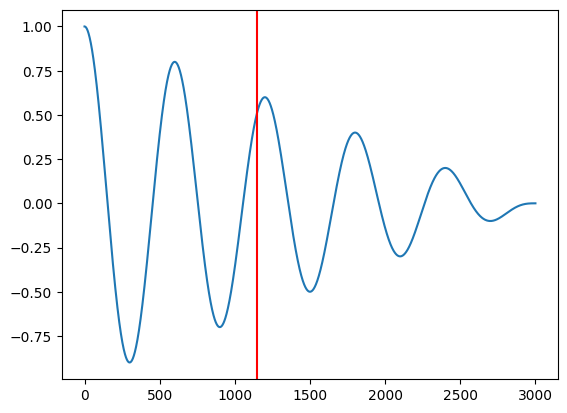

In [135]:
plt.plot(autocorr)
plt.axvline(lag, color='r')

In [137]:
from statsmodels.tsa import stattools

def autocorrelation_function_width(sig: np.ndarray) -> int:
    """Computes the ACFW (autocorrelation function width) for a signal.
    The ACFW is the lag at which the autocorrelation is half its maximum value.
    :param sig: signal to compute ACFW for
    :return: ACFW width (lag)
    """
    # compute autocorrelation for all lags
    autocorr = stattools.acf(sig, nlags=len(sig), fft=True)
    assert autocorr.max() == 1, "Autocorrelation max isn't 1"

    # Find the lag (index) where the ACF is closest to its half-max (=0.5)
    # The half-max is 0.5 because the maximum autocorrelation is 1
    # Subtracting 0.5 makes the values close to 0.5 become close to 0
    # Taking the absolute values makes values close to 0 be the minimal elements
    # Then, the argmin is taken to find the value closest to 0 (the half-max index/lag)
    return np.abs(autocorr - 0.5).argmin()


In [143]:
timeit.timeit('autocorrelation_function_width(s)', number=10000, globals=globals())

1.1015114579931833